In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from cryoenv.mqtt import generate_sweep

%config InlineBackend.figure_formats = ['svg']

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 50 sample avg

0.9961726461097314 -0.7044004332967378
1.3881065801954797 -0.29947977994196845
5.043699130130081 -0.2740452570326612


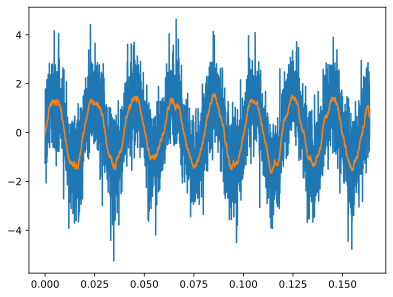

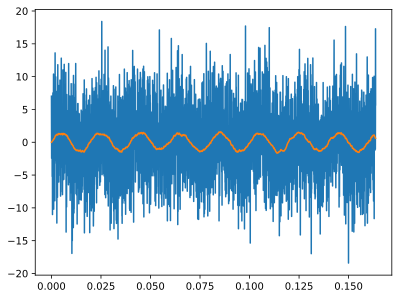

In [2]:
t = np.arange(0,4092)/25000
fifty = np.sin(2*np.pi*t*50)*np.sqrt(2)
freq_sc = fifty + np.random.normal(scale=1,size=4092)
freq_nc = fifty + np.random.normal(scale=5,size=4092)

print(np.std(fifty), - np.std(fifty)/np.max(fifty))
print(np.std(freq_sc), - np.std(freq_sc)/np.max(freq_sc))
print(np.std(freq_nc), - np.std(freq_nc)/np.max(freq_nc))

for fq in [freq_sc, freq_nc]:
    plt.plot(t,fq)
    plt.plot(t, np.convolve(freq_sc, np.ones(50)/50, mode='same'))
    plt.show()


# relaxation of DAC

In [3]:
class DAC:
    def __init__(self, init_value=0., tau=45, dt=10):
        self.init_value = init_value
        self.value = init_value
        self.trajectory = [init_value]
        self.tau = 45
        self.dt = 10
        self.alpha = np.exp(-dt/tau)
    def step(self):
        self.value = self.value * self.alpha - (1 - self.alpha) * np.random.uniform(-1,1)
        self.trajectory.append(np.copy(self.value))
    def get_trajectory(self):
        return np.array(self.trajectory)
    def get_time(self):
        return self.dt*np.arange(len(self.trajectory))
    def get_expected_value(self):
        n = len(self.trajectory)
        i = np.arange(n)
        return self.init_value * np.exp(-i*self.dt/self.tau)
    def get_std(self):
        n = len(self.trajectory)
        i = np.arange(n)
        std = np.array([np.sum(np.exp(-2*np.arange(idx)*self.dt/self.tau)) for idx in i])
        return (1 - self.alpha) * np.sqrt(std / 3)

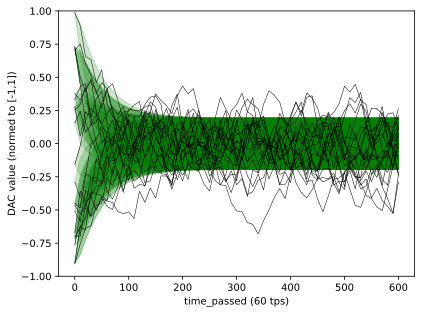

In [4]:
episodes = 20
length_episode = 60

for i in range(episodes):
    if i < 100000: 
        dac = DAC(np.random.uniform(-1,1))  # init_value=np.random.choice([-1,1])) # 
    else:
        dac = DAC(init_value=0.)
    for _ in range(length_episode):
        dac.step()
    plt.plot(dac.get_time(), dac.get_trajectory(), color='black', linewidth=0.5)

    # plt.plot(dac.get_time(), dac.get_expected_value(), color='green', linewidth=2.5, label='expected value' if i == 19 else '')
    plt.fill_between(dac.get_time(), dac.get_expected_value() - dac.get_std(), dac.get_expected_value() + dac.get_std(), alpha=0.2, color='green')
plt.xlabel('time_passed ({} tps)'.format(len(dac.trajectory) - 1))
plt.ylabel('DAC value (normed to [-1,1])')
#plt.legend()
plt.ylim(-1,1)
plt.show()

# fast sweep

In [5]:
ops = generate_sweep(12, 10)  # 12, 10  # 8, 5

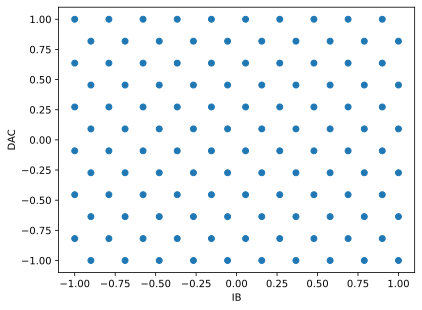

In [6]:
plt.scatter(ops[:,1], ops[:,0])
plt.ylabel('DAC')
plt.xlabel('IB')
plt.show()

# the gamma value

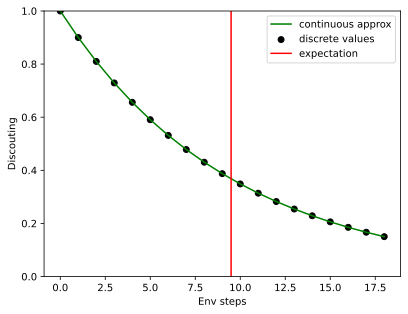

In [7]:
gamma = 0.9

time_scale = -1/np.log(gamma)

steps = np.arange(0,np.ceil(2*time_scale))

discounting = np.array([gamma**s for s in steps])

plt.plot(steps, np.exp(-steps/time_scale), label='continuous approx', color='green')
plt.scatter(steps, discounting, label='discrete values', color='black')
plt.axvline(time_scale, label='expectation', color='red')
plt.legend()
plt.xlabel('Env steps')
plt.ylabel('Discouting')
plt.ylim(0,1)
plt.show()

# the tau value

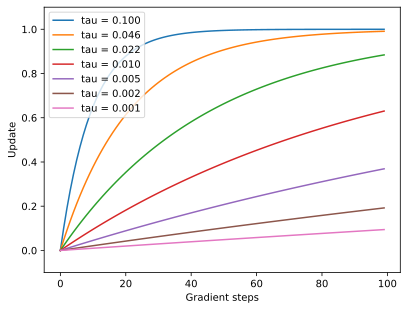

In [8]:
for tau in np.logspace(-1,-3,7):

    gradient_steps = np.arange(0,100)
    start = 0
    target = 1

    update = [(1-tau)**g * start + (1 - (1-tau)**g) * target for g in gradient_steps]

    plt.plot(gradient_steps, update, label='tau = {:.3f}'.format(tau))

plt.legend()
plt.xlabel('Gradient steps')
plt.ylabel('Update')
plt.ylim(-0.1, 1.1)
plt.show()

# the omega value

# covariance or derivative

In [12]:
ddac = 0.1
dcph = 0.05
dac = np.array([1.56, 1.56 + ddac])
cph = np.array([2.1, 2.1 + dcph])

In [13]:
np.cov(dac, cph)[0,1]

0.0024999999999999935

In [14]:
(dcph * np.random.normal(scale=dcph/5))/(ddac + 1e-5)

0.006076410799427612

# plot buffer

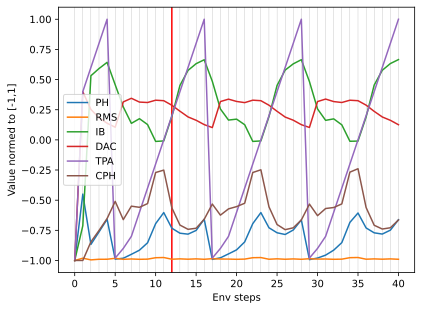

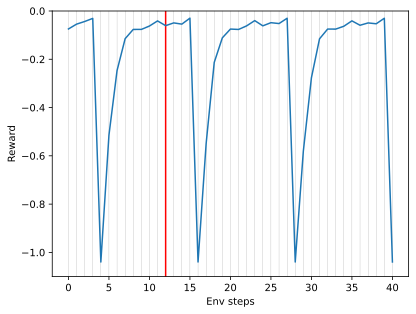

In [15]:
# idx = 4
path = '../../../rltest_data/mqtt_tests/runs/firstv1_44/'
path_data = path + 'data/inference/'  # inference/
buffer_size = 1300
names = ['PH', 'RMS', 'IB', 'DAC', 'TPA', 'CPH']  # , 'TPA', 'CPH', ''
n_obs = len(names)
idx_current = 12
idx_max = 16
idx_min = 11

total = np.memmap(path_data + 'buffer_total.npy', dtype=int, mode='r', shape=(1,))
counter = np.memmap(path_data + 'buffer_counter.npy', dtype=int, mode='r', shape=(1,))
x = np.memmap(path_data + 'state_memory.npy', dtype=float, mode='r', shape=(buffer_size,n_obs))
a = np.memmap(path_data + 'action_memory.npy', dtype=float, mode='r', shape=(buffer_size,2))
y = np.memmap(path_data + 'reward_memory.npy', dtype=float, mode='r', shape=(buffer_size,))

for i in range(41):
    plt.axvline(i, linewidth=.2, color='grey')
plt.axvline(idx_current, linewidth=1.5, color='red')
plt.plot(x[:total[0],0], label=names[0])  # total[0]
plt.plot(x[:total[0],1], label=names[1])  # total[0]
plt.plot(x[:total[0],2], label=names[2])  # total[0]
plt.plot(x[:total[0],3], label=names[3])  # total[0]
if n_obs > 4:
    plt.plot(x[:total[0],4], label=names[4])  # total[0]
if n_obs > 5:
    plt.plot(x[:total[0],5], label=names[5])  # total[0]
plt.xlabel('Env steps')
plt.ylabel('Value normed to [-1,1]')
plt.ylim(-1.1, 1.1)
plt.legend()
plt.show()

for i in range(41):
    plt.axvline(i, linewidth=.2, color='grey')
plt.axvline(idx_current, linewidth=1.5, color='red')
plt.plot(y[:total[0]])
plt.xlabel('Env steps')
plt.ylabel('Reward')
plt.ylim(-1.1,0)
plt.show()

In [16]:
print('Action, DAC: {}, IB: {}'.format(5*(a[22, 0] + 1)/2, 4.5*(a[22, 1] + 1)/2 + 0.5))

Action, DAC: 3.3119211196899414, IB: 2.7300927556794266


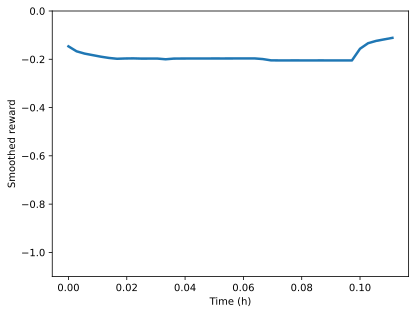

In [17]:
plt.plot(10*np.arange(0,total[0],1)/3600, np.convolve(y[:total[0]], np.ones(12)/12, mode='same'), linewidth=2.5)
plt.ylabel('Smoothed reward')
plt.xlabel('Time (h)')
plt.ylim(-1.1,0)
plt.show()

# plot policy and value net

In [22]:
from cryoenv.mqtt import QNetwork, GaussianPolicy
import torch
import os

path_models = path + 'models/'

policy = GaussianPolicy(n_obs, 2)
policy.load_state_dict(torch.load(os.path.join(path_models, "policy.pt"), map_location=device))#, map_location=device))
target_critic = QNetwork(n_obs, 2)
target_critic.load_state_dict(torch.load(os.path.join(path_models, "target_critic.pt"), map_location=device))#, map_location=device))  # target_critic critic

<All keys matched successfully>

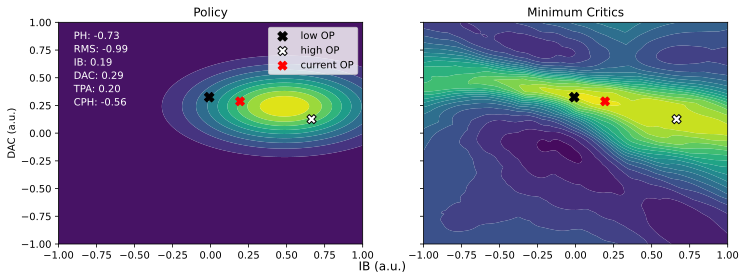

In [27]:
from scipy.stats import multivariate_normal

plot_scatter = True
min_critics = True 

obs = torch.tensor(x[idx_current], dtype=torch.float32).reshape(1, -1) 
# obs = torch.tensor([-1., -1., .369, -.38, .0]).reshape(1, -1)  # PH, RMS, IB, DAC, CPH
#obs[0,0] = -0.4
min_obs = torch.tensor(x[idx_min], dtype=torch.float32).reshape(1, -1) 
max_obs = torch.tensor(x[idx_max], dtype=torch.float32).reshape(1, -1) 

mu, log_std = policy(obs)
mu = mu.detach().numpy().flatten()
with torch.no_grad():
    log_std = log_std.numpy().flatten()

rv = multivariate_normal(mu, np.diag(np.exp(log_std)))

x_grid, y_grid = np.mgrid[-1:1.01:.01, -1:1.01:.01]
pos = np.dstack((x_grid, y_grid))


action = torch.tensor([[x_,y_] for x_,y_ in zip(x_grid.flatten(), y_grid.flatten())], dtype=torch.float32)  # , dtype=torch.float32

with torch.no_grad():
    val1, val2 = target_critic(torch.tile(obs, (40401,1)), action)
    val_min = torch.min(val1, val2)

fig, ax = plt.subplots(1,2 if min_critics else 3,dpi=100,figsize=(12,4), sharex=True, sharey=True)

ax[0].contourf(y_grid, x_grid, rv.pdf(pos), levels=10)  # IB, DAC
if plot_scatter:
    ax[0].scatter(min_obs[0,2], min_obs[0,3], color='black', edgecolor='black', s=100*(min_obs[0,0]+1) + 50, marker='X', label='low OP')
    ax[0].scatter(max_obs[0,2], max_obs[0,3], color='white', edgecolor='black', s=100*(max_obs[0,0]+1) + 50, marker='X', label='high OP')
    ax[0].scatter(obs[0,2], obs[0,3], color='red', s=100*(obs[0,0]+1) + 50, marker='X', label='current OP')
    ax[0].legend()

for i,n in enumerate(names):
    ax[0].text(-0.9, 0.85 - i*0.12, '{}: {:.2f}'.format(n, obs[0,i]), color='white')
ax[0].set_ylabel('DAC (a.u.)')
ax[0].set_title('Policy')
if not min_critics:
    ax[1].contourf(y_grid, x_grid, val1.reshape(201,201), levels=20)  # IB, DAC
    if plot_scatter:
        ax[1].scatter(min_obs[0,2], min_obs[0,3], color='black', edgecolor='black', s=100*(min_obs[0,0]+1) + 50, marker='X')
        ax[1].scatter(max_obs[0,2], max_obs[0,3], color='white', edgecolor='black', s=100*(max_obs[0,0]+1) + 50, marker='X')
        ax[1].scatter(obs[0,2], obs[0,3], color='red', s=100*(obs[0,0]+1) + 50, marker='X', label='current OP')
    ax[1].set_title('Critic 1')
    ax[2].contourf(y_grid, x_grid, val2.reshape(201,201), levels=20)  # IB, DAC
    if plot_scatter:
        ax[2].scatter(min_obs[0,2], min_obs[0,3], color='black', edgecolor='black', s=100*(min_obs[0,0]+1) + 50, marker='X')
        ax[2].scatter(max_obs[0,2], max_obs[0,3], color='white', edgecolor='black', s=100*(max_obs[0,0]+1) + 50, marker='X')
        ax[1].scatter(obs[0,2], obs[0,3], color='red', s=100*(obs[0,0]+1) + 50, marker='X', label='current OP')
    ax[2].set_title('Critic 2')
else:
    ax[1].contourf(y_grid, x_grid, val_min.reshape(201,201), levels=20)  # IB, DAC
    if plot_scatter:
        ax[1].scatter(min_obs[0,2], min_obs[0,3], color='black', edgecolor='black', s=100*(min_obs[0,0]+1) + 50, marker='X')
        ax[1].scatter(max_obs[0,2], max_obs[0,3], color='white', edgecolor='black', s=100*(max_obs[0,0]+1) + 50, marker='X')
        ax[1].scatter(obs[0,2], obs[0,3], color='red', s=100*(obs[0,0]+1) + 50, marker='X', label='current OP')
    ax[1].set_title('Minimum Critics')
    
plt.xlim(-1,1)
plt.ylim(-1,1)
fig.supxlabel('IB (a.u.)')
plt.show()

In [24]:
print('Estimated avg reward: {}'.format(val1.max() / (1 / (1 - 0.99)) ))

Estimated avg reward: -0.2472861111164093


In [25]:
2.9*(x[18, 2] + 1)/2 + 0.1  # IB

1.921387314796448

In [26]:
10*(x[18, 3] + 1)/2 + 0.  # DAC

6.587526321411133